## Fresh or Rotten Classification using CNN

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"

In [3]:
%cd /kaggle

/kaggle


The dataset is uploaded to Kaggle and then imported into this project

In [4]:
!kaggle datasets download -d eislax/fresh-and-rotten-fruit-dataset-4fruit

Dataset URL: https://www.kaggle.com/datasets/eislax/fresh-and-rotten-fruit-dataset-4fruit
License(s): Apache 2.0
100% 2.74G/2.75G [00:27<00:00, 135MB/s]
100% 2.75G/2.75G [00:27<00:00, 106MB/s]


In [5]:
!unzip fresh-and-rotten-fruit-dataset-4fruit.zip -d dataset-fruitsnap

Streaming output truncated to the last 5000 lines.
  inflating: dataset-fruitsnap/dataset_fix/train/rottenstrawberry/997.jpg  
  inflating: dataset-fruitsnap/dataset_fix/train/rottenstrawberry/rottenStrawberries (103).jpg  
  inflating: dataset-fruitsnap/dataset_fix/train/rottenstrawberry/rottenStrawberries (104).jpg  
  inflating: dataset-fruitsnap/dataset_fix/train/rottenstrawberry/rottenStrawberries (105).jpg  
  inflating: dataset-fruitsnap/dataset_fix/train/rottenstrawberry/rottenStrawberries (112).jpg  
  inflating: dataset-fruitsnap/dataset_fix/train/rottenstrawberry/rottenStrawberries (113).jpg  
  inflating: dataset-fruitsnap/dataset_fix/train/rottenstrawberry/rottenStrawberries (114).jpg  
  inflating: dataset-fruitsnap/dataset_fix/train/rottenstrawberry/rottenStrawberries (115).jpg  
  inflating: dataset-fruitsnap/dataset_fix/train/rottenstrawberry/rottenStrawberries (116).jpg  
  inflating: dataset-fruitsnap/dataset_fix/train/rottenstrawberry/rottenStrawberries (117).jpg  


In [6]:
train_dir = "/kaggle/dataset-fruitsnap/dataset_fix/train"
test_dir = "/kaggle/dataset-fruitsnap/dataset_fix/test"
val_dir = "/kaggle/dataset-fruitsnap/dataset_fix/val"

#### Augmentation image process

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

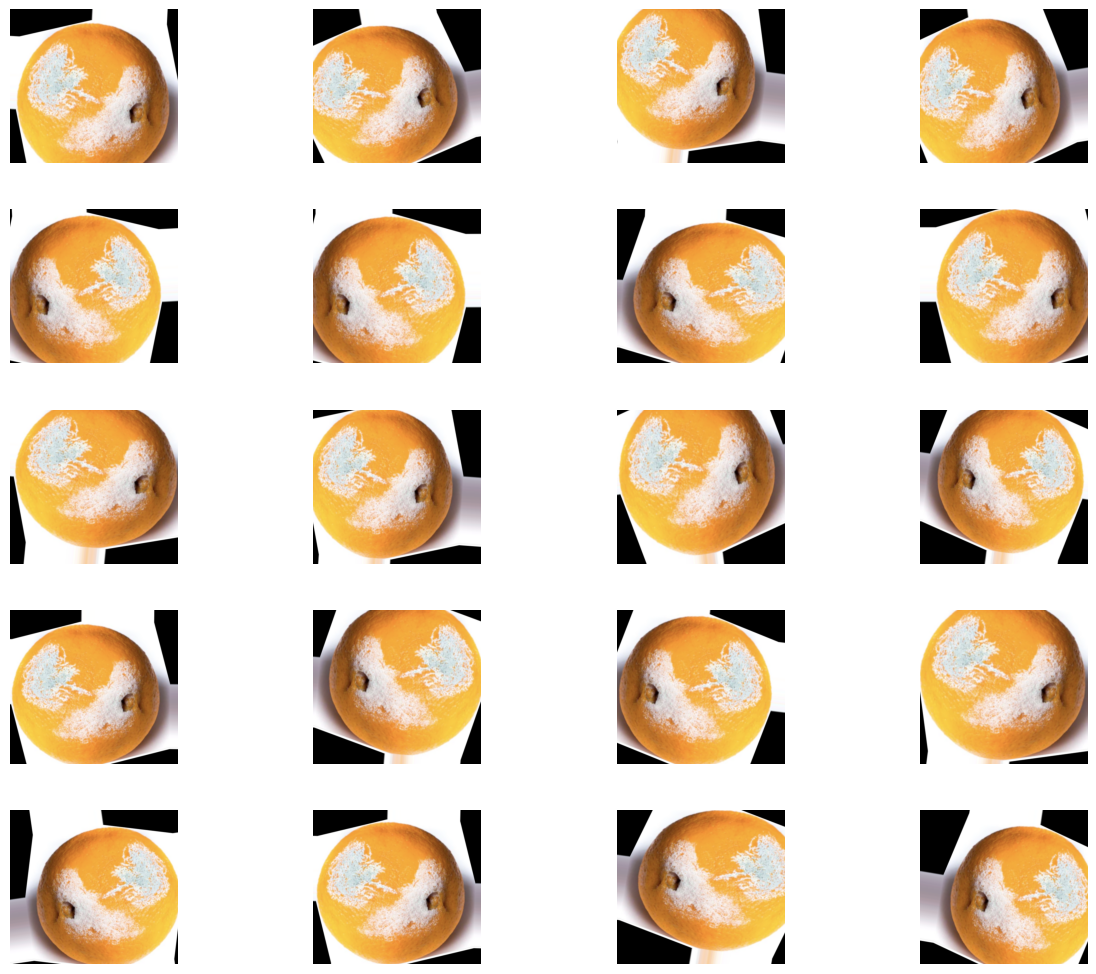

In [8]:
sample_category = os.listdir(train_dir)[0]
sample_image_path = os.path.join(train_dir, sample_category, os.listdir(os.path.join(train_dir, sample_category))[-1])
img_augmentation = image.load_img(sample_image_path)
x_aug = image.img_to_array(img_augmentation)
x_aug = x_aug.reshape((1,) + x_aug.shape)

augmented_images = []
i = 0
for batch in train_datagen.flow(x_aug, batch_size=1):
    augmented_images.append(image.array_to_img(batch[0]))
    i += 1
    if i >= 20:
        break

plt.figure(figsize=(15, 15))
for n in range(len(augmented_images)):
    plt.subplot((len(augmented_images) // 4) + 1, 4, n + 1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(augmented_images[n])
    plt.axis('off')
plt.show()

In [9]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=64,
                                                    color_mode="rgb",
                                                    target_size=(150,150),
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                         batch_size=64,
                                                         color_mode="rgb",
                                                         target_size=(150,150),
                                                         class_mode='categorical')

num_classes = len(train_generator.class_indices)

Found 9183 images belonging to 8 classes.
Found 4537 images belonging to 8 classes.


#### Modeling Process

Early stopping will be **triggered** if the validation loss does not improve for **10 consecutive iterations**, restoring the best model weights.  

The `ReduceLROnPlateau` callback reduces the learning rate by a factor of **0.2** if the validation loss does not improve for **5 iterations**, with a minimum learning rate of **1e-5**.

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [12]:
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 72, 72, 64)        256       
 chNormalization)                                                
                                                        

add pretrained model using InceptionV3

In [13]:
pre_trained_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights='imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False

#Custom layer
x = layers.Flatten()(pre_trained_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(num_classes, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization_4 (Bat  (None, 74, 74, 32)           96        ['conv2d_4[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)     

In [14]:
model.fit(
    train_generator,
    epochs=10,
    verbose=1,
    callbacks=[early_stopping, reduce_lr],
    validation_data=validation_generator
)

Epoch 1/10
144/144 [==============================] - 134s 852ms/step - loss: 7.9451 - accuracy: 0.7873 - val_loss: 0.5613 - val_accuracy: 0.9065 - lr: 0.0010
Epoch 2/10
144/144 [==============================] - 114s 793ms/step - loss: 0.6495 - accuracy: 0.8846 - val_loss: 0.2744 - val_accuracy: 0.9306 - lr: 0.0010
Epoch 3/10
144/144 [==============================] - 134s 930ms/step - loss: 0.4850 - accuracy: 0.9010 - val_loss: 0.1439 - val_accuracy: 0.9559 - lr: 0.0010
Epoch 4/10
144/144 [==============================] - 115s 802ms/step - loss: 0.3570 - accuracy: 0.9229 - val_loss: 0.1523 - val_accuracy: 0.9599 - lr: 0.0010
Epoch 5/10
144/144 [==============================] - 114s 793ms/step - loss: 0.3104 - accuracy: 0.9329 - val_loss: 0.2133 - val_accuracy: 0.9486 - lr: 0.0010
Epoch 6/10
144/144 [==============================] - 115s 797ms/step - loss: 0.3080 - accuracy: 0.9351 - val_loss: 0.1162 - val_accuracy: 0.9696 - lr: 0.0010
Epoch 7/10
144/144 [==========================

##### Fine Tuning Model

In [20]:
# Unfreeze the top layers of the pre-trained model
for layer in pre_trained_model.layers[-4:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=RMSprop(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
history = model.fit(
    train_generator,
    epochs=20,  # Increase the number of epochs
    verbose=1,
    callbacks=[early_stopping, reduce_lr],
    validation_data=validation_generator
)


Epoch 1/20
144/144 [==============================] - 149s 841ms/step - loss: 0.2252 - accuracy: 0.9305 - val_loss: 0.0951 - val_accuracy: 0.9676 - lr: 1.0000e-05
Epoch 2/20
144/144 [==============================] - 123s 855ms/step - loss: 0.1306 - accuracy: 0.9603 - val_loss: 0.0636 - val_accuracy: 0.9795 - lr: 1.0000e-05
Epoch 3/20
144/144 [==============================] - 120s 831ms/step - loss: 0.0915 - accuracy: 0.9735 - val_loss: 0.0485 - val_accuracy: 0.9857 - lr: 1.0000e-05
Epoch 4/20
144/144 [==============================] - 121s 841ms/step - loss: 0.0759 - accuracy: 0.9780 - val_loss: 0.0360 - val_accuracy: 0.9896 - lr: 1.0000e-05
Epoch 5/20
144/144 [==============================] - 122s 846ms/step - loss: 0.0527 - accuracy: 0.9854 - val_loss: 0.0299 - val_accuracy: 0.9916 - lr: 1.0000e-05
Epoch 6/20
144/144 [==============================] - 120s 836ms/step - loss: 0.0505 - accuracy: 0.9865 - val_loss: 0.0288 - val_accuracy: 0.9923 - lr: 1.0000e-05
Epoch 7/20
144/144 [==

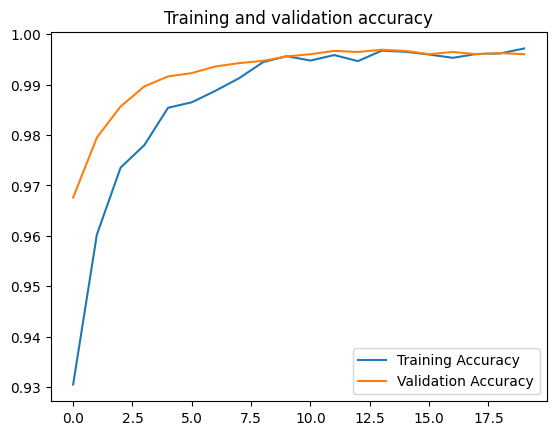

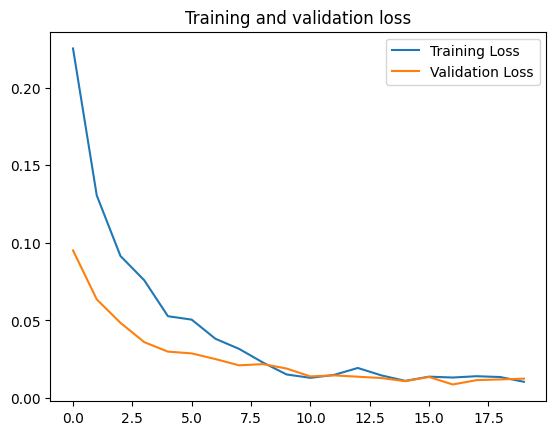

In [22]:
import matplotlib.pyplot as plt
acc = history.history['accuracy' ]
val_acc = history.history['val_accuracy' ]
loss = history.history['loss' ]
val_loss = history.history['val_loss' ]
epochs = range(len(acc))

# Plot training and validation accuracy
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plot training and validation loss
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=32,
                                                  target_size=(150, 150),
                                                  shuffle = False,
                                                  class_mode='categorical')

filenames = test_generator.filenames
nb_samples = len(filenames)

loss, acc = model.evaluate(test_generator,steps = (nb_samples), verbose=1)
print('accuracy test: ',acc)

Found 3478 images belonging to 8 classes.
 109/3478 [..............................] - ETA: 13:58 - loss: 0.0118 - accuracy: 0.9971

3478/3478 [==============================] - 30s 8ms/step - loss: 0.0118 - accuracy: 0.9971
accuracy test:  0.9971247911453247


In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Mengambil prediksi dan label sebenarnya
val_preds = model.predict(validation_generator)
val_preds_classes = np.argmax(val_preds, axis=1)
true_classes = validation_generator.classes

# Confusion matrix
cm = confusion_matrix(true_classes, val_preds_classes)
print(cm)

# Classification report
class_labels = list(validation_generator.class_indices.keys())
report = classification_report(true_classes, val_preds_classes, target_names=class_labels)
print(report)

71/71 [==============================] - 28s 390ms/step
[[ 63  57  59  61 101  96  67  54]
 [ 73  49  54  44  90  93  54  64]
 [ 59  51  46  48  83  80  62  54]
 [ 61  45  47  55  80  68  55  52]
 [ 89  82  83  79 133 117 104  85]
 [ 86  94  90  81 127 114  67  74]
 [ 65  81  52  50  84  83  54  53]
 [ 63  61  48  49  82  80  57  45]]
                  precision    recall  f1-score   support

     freshapples       0.11      0.11      0.11       558
     freshbanana       0.09      0.09      0.09       521
    freshoranges       0.10      0.10      0.10       483
 freshstrawberry       0.12      0.12      0.12       463
     rottenaples       0.17      0.17      0.17       772
    rottenbanana       0.16      0.16      0.16       733
   rottenoranges       0.10      0.10      0.10       522
rottenstrawberry       0.09      0.09      0.09       485

        accuracy                           0.12      4537
       macro avg       0.12      0.12      0.12      4537
    weighted avg       

The accuracy and validation loss look great! However, the model appears to be **overfitting**, as seen in the classification report, which shows low scores for each class.

In [26]:
model.save('model/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## -----------------------------------------------------------------------------------------------------------------------------

### Predict the image using model

In [27]:
model_predict = tf.keras.models.load_model('/kaggle/model/model.h5')

Saving apple seger.jpg to apple seger (2).jpg
Saving applebusuk.jpg to applebusuk (2).jpg
Saving AR1.jpg to AR1 (2).jpg
Saving AR2.jpg to AR2 (2).jpg
Saving freshstrawberry.jpg to freshstrawberry (2).jpg
Saving freshstrawberry11.jpg to freshstrawberry11 (3).jpg
Saving images.jpg to images.jpg
Saving jerukbusukndirian.jpg to jerukbusukndirian (2).jpg
Saving orange-fruit.jpg to orange-fruit (2).jpg
Saving pisangdewekan.jpg to pisangdewekan (2).jpg
Saving rotten_orange.jpg to rotten_orange.jpg
Saving rotten_straw.png to rotten_straw (1).png
Saving rottenapple.jpg to rottenapple (2).jpg
Saving sangbusuk.jpg to sangbusuk (2).jpg
Saving straw_rotten.png to straw_rotten (1).png
1/1 [==============================] - 0s 29ms/step
Predicted class: freshapples, Accuracy: 100.00%


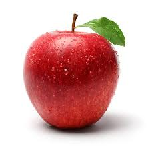

1/1 [==============================] - 0s 25ms/step
Predicted class: rottenapples, Accuracy: 99.98%


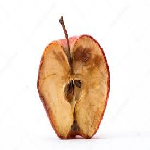

1/1 [==============================] - 0s 25ms/step
Predicted class: rottenapples, Accuracy: 100.00%


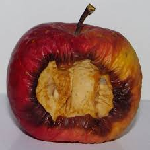

1/1 [==============================] - 0s 35ms/step
Predicted class: rottenapples, Accuracy: 99.22%


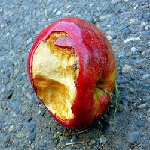

1/1 [==============================] - 0s 39ms/step
Predicted class: freshstrawberry, Accuracy: 99.50%


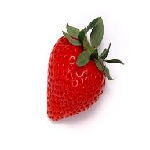

1/1 [==============================] - 0s 41ms/step
Predicted class: freshstrawberry, Accuracy: 76.66%


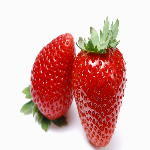

1/1 [==============================] - 0s 36ms/step
Predicted class: rottenbanana, Accuracy: 100.00%


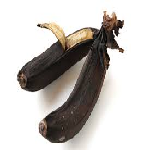

1/1 [==============================] - 0s 46ms/step
Predicted class: rottenoranges, Accuracy: 100.00%


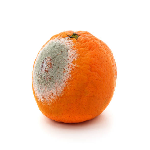

1/1 [==============================] - 0s 40ms/step
Predicted class: freshoranges, Accuracy: 100.00%


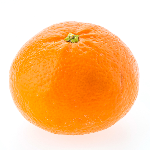

1/1 [==============================] - 0s 38ms/step
Predicted class: freshbanana, Accuracy: 100.00%


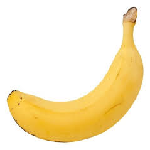

1/1 [==============================] - 0s 36ms/step
Predicted class: rottenoranges, Accuracy: 100.00%


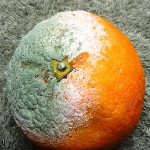

1/1 [==============================] - 0s 42ms/step
Predicted class: rottenstrawberry, Accuracy: 68.73%


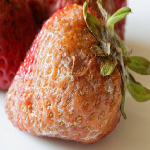

1/1 [==============================] - 0s 36ms/step
Predicted class: rottenapples, Accuracy: 100.00%


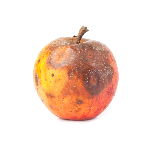

1/1 [==============================] - 0s 39ms/step
Predicted class: rottenbanana, Accuracy: 100.00%


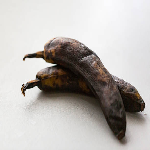

1/1 [==============================] - 0s 47ms/step
Predicted class: rottenstrawberry, Accuracy: 99.92%


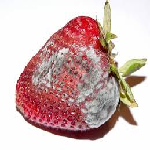

In [32]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    img = image.load_img(fn, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model_predict.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)

    class_labels = list(train_generator.class_indices.keys())
    predicted_label = class_labels[predicted_class[0]]
    accuracy = prediction[0][predicted_class[0]] * 100
    print(f"Predicted class: {predicted_label}, Accuracy: {accuracy:.2f}%")
    display(img)


Saving apple seger.jpg to apple seger (3).jpg
Saving applebusuk.jpg to applebusuk (3).jpg
Saving AR1.jpg to AR1 (3).jpg
Saving AR2.jpg to AR2 (3).jpg
Saving freshstraw.jpg to freshstraw.jpg
Saving freshstrawberry.jpg to freshstrawberry (3).jpg
Saving freshstrawberry11.jpg to freshstrawberry11 (4).jpg
Saving images.jpg to images (1).jpg
Saving jerukbusukndirian.jpg to jerukbusukndirian (3).jpg
Saving orange-fruit.jpg to orange-fruit (3).jpg
Saving pisangbenyek.jpg to pisangbenyek (2).jpg
Saving pisangdewekan.jpg to pisangdewekan (3).jpg
Saving rotten_orange.jpg to rotten_orange (1).jpg
Saving rotten_straw.png to rotten_straw (2).png
Saving rottenapple.jpg to rottenapple (3).jpg
Saving sangbusuk.jpg to sangbusuk (3).jpg
Saving straw_rotten.png to straw_rotten (2).png
1/1 [==============================] - 0s 24ms/step


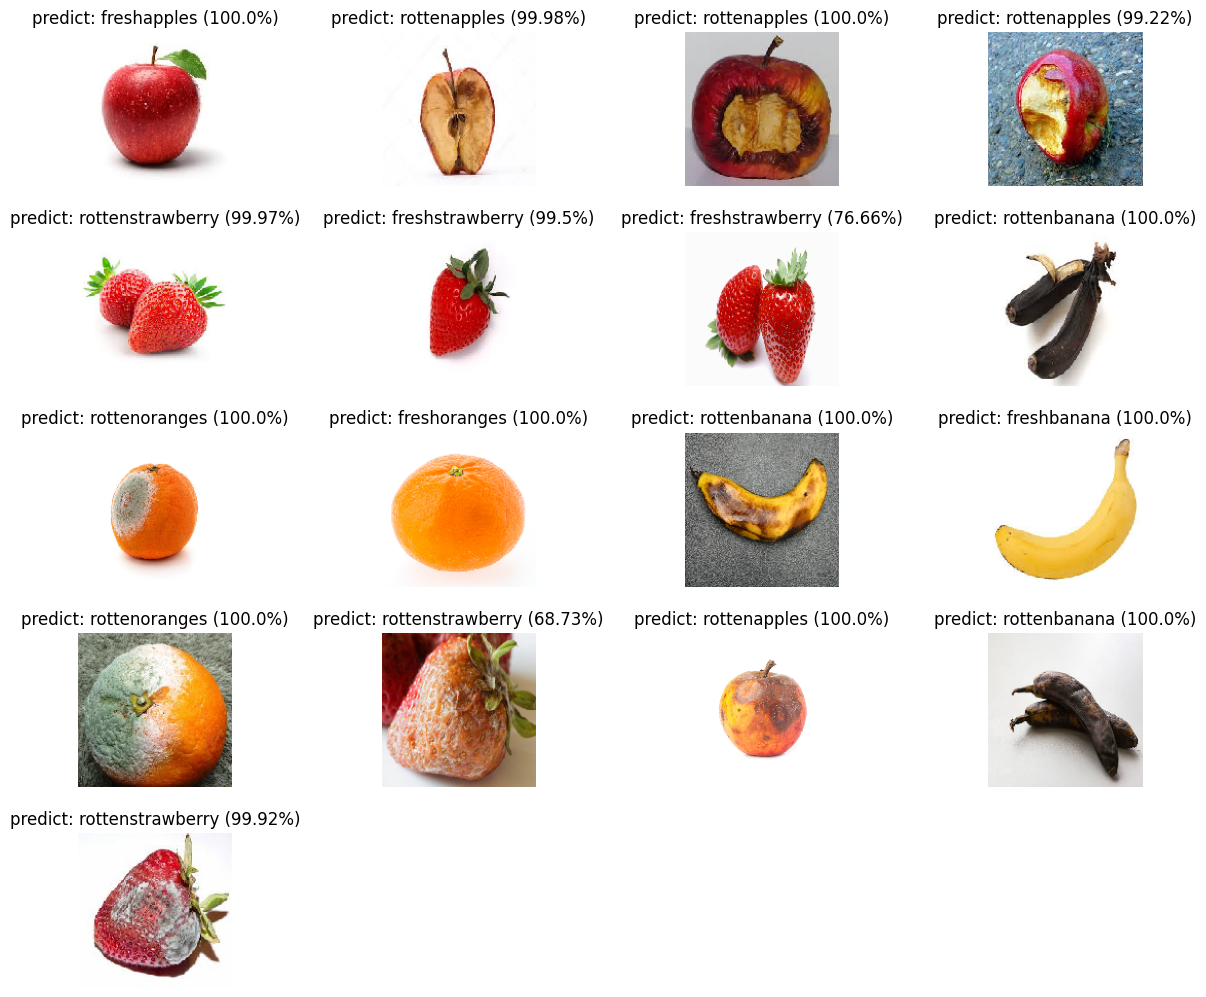

In [33]:
import numpy as np
from google.colab import files
import math

class_labels = list(train_generator.class_indices.keys())

uploaded = files.upload()
image_name = []
image_conf = []
predict_result = []

for fn in uploaded.keys():
    img = image.load_img(fn, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model_predict.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)

    predict_result.append(class_labels[predicted_class[0]])
    image_name.append(fn)
    image_conf.append(prediction[0][predicted_class[0]])

plt.figure(figsize=(15, 15))
for i in range(len(image_name)):
    plt.subplot(math.ceil(len(image_name) / 4) + 1, 4, i + 1)
    plt.subplots_adjust(hspace=0.3)

    img_rgb = image.load_img(image_name[i], target_size=(150, 150))

    plt.imshow(img_rgb)
    title = f"predict: {predict_result[i]} ({round(float(image_conf[i]) * 100, 2)}%)"
    plt.title(title, color='black')
    plt.axis('off')
plt.show()

for fn in image_name:
    os.remove(fn)
